<div align="center">

# Instituto Tecnológico y de Estudios Superiores de Monterrey

**Septiembre–Diciembre 2025**
**Maestría en Inteligencia Artificial Aplicada**

## Avance 3

**Baseline**

---

### Equipo académico

|                  | **Nombre**                            |
| ---------------- | ------------------------------------- |
| Profesor Titular | Dra. Grettel Barceló Alonso           |
| Asesora          | Dra. Ludivina Facundo Flores          |
| Tutor            | Mtra. Verónica Sandra Guzmán de Valle |
| Sponsor          | Dr. Jesús Arturo Pérez Díaz           |

---

### Proyecto Integrador

**TC5035.10**

---

### Integrantes

| **Nombre**                        | **Matrícula** |
| --------------------------------- | ------------- |
| Christopher Adolfo Orduña De León | A01795372     |
| Miguel Ángel Paredes Gutiérrez    | A01794138     |
| Carlos Mariano Ramírez Amaya      | A01795036     |

**Fecha:** 12 de Octubre del 2025

</div>


In [1]:
import os
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
PATH = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\data\processed\chinatelecom_april_08_2010_output.parquet'

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))
display(df.head(5))

Shape:  (326208, 15)
Columnas: ['time', 'prefix', 'origin', 'type', 'as_path', 'as_path_length', 'secs_between_announcements', 'unique_as_in_path', 'as_path_length_diff_A', 'as_path_length_diff_A_abs', 'origin_at_time_nuniq', 'MOAS', 'as_path_embedding', 'prev_embedding', 'cosine_distance_prev_A']


,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
0,1.270749e+09,109.106.128.0/19,43727,A,4826 703 9929 4134 39792 43727,6,NaN,6,NaN,NaN,1,0,"[-0.039181534, -0.023284597, -0.11239016, 0.05...",None,NaN
1,1.270750e+09,109.106.32.0/19,34881,A,19151 3249 6747 34881,4,NaN,4,NaN,NaN,1,0,"[-0.09213456, -0.031599678, -0.09557211, 0.008...",None,NaN
2,1.270750e+09,109.109.208.0/20,21332,A,14537 8359 8359 8359 8359 8359 6854 21332,8,NaN,4,NaN,NaN,1,0,"[0.06650425, -0.051212557, -0.035398424, -0.04...",None,NaN
3,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 8359 8359 8359 8359 8359 6854...,10,17.0,6,2.0,2.0,2,1,"[-0.052564204, 0.026770383, -0.10509007, -0.00...","[0.06650425, -0.051212557, -0.035398424, -0.04...",0.343521
4,1.270750e+09,109.109.208.0/20,21332,A,196613 1125 1103 6453 20485 21332,6,0.0,6,-4.0,-4.0,2,1,"[-0.09425271, 0.045285292, -0.095429935, -0.02...","[-0.052564204, 0.026770383, -0.10509007, -0.00...",0.081563


In [3]:
df.sort_values(by='time').reset_index(drop=True)

,time,prefix,origin,type,as_path,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
0,1.270749e+09,113.190.64.0/19,45899,A,6067 286 1299 7643 45899,5,NaN,5,NaN,NaN,1,0,"[-0.076579764, -0.01646377, -0.15311255, 0.035...",None,NaN
1,1.270749e+09,131.87.181.0/24,27046,A,3561 1239 721 27064 27046,5,NaN,5,NaN,NaN,1,0,"[-0.07314509, -0.06986856, -0.035867047, -0.00...",None,NaN
2,1.270749e+09,113.190.128.0/19,45899,A,6067 286 1299 7643 45899,5,NaN,5,NaN,NaN,1,0,"[-0.07657978, -0.016463753, -0.15311258, 0.035...",None,NaN
3,1.270749e+09,119.235.26.0/24,24532,A,2914 6453 18351 24532,4,NaN,4,NaN,NaN,1,0,"[-0.07192664, -0.053233534, -0.069591686, 0.02...",None,NaN
4,1.270749e+09,123.26.224.0/19,45899,A,6067 286 3320 7643 45899,5,NaN,5,NaN,NaN,1,0,"[-0.09296992, -0.032037325, -0.16861348, 0.010...",None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326203,1.270750e+09,198.176.186.0/23,36416,A,196613 1125 1103 6453 174 3933 36416,7,1.0,7,3.0,3.0,1,0,"[-0.078113206, 0.039025243, -0.11018381, -0.00...","[-0.033563145, -0.07313901, -0.12083216, 0.000...",0.430742
326204,1.270750e+09,198.236.0.0/18,36416,A,196613 1125 1103 6453 174 3933 36416,7,1.0,7,3.0,3.0,1,0,"[-0.078113206, 0.039025243, -0.11018381, -0.00...","[-0.033563145, -0.07313901, -0.12083216, 0.000...",0.430742
326205,1.270750e+09,55.196.34.0/24,None,W,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
326206,1.270750e+09,195.112.104.0/24,8636,A,3257 1299 20485 8636,4,9.0,4,0.0,0.0,1,0,"[-0.06724058, -0.06922233, -0.037761547, 0.009...","[-0.037278526, -0.07372972, -0.07832932, 0.053...",0.195059


In [4]:
embedding_size = df['as_path_embedding'][0].shape
print(f'Tamaño del embedding: {embedding_size}')

Tamaño del embedding: (384,)


## Generación de entradas a utilizar por el modelo

**¿Se puede determinar la importancia de las características para el modelo generado?**
 
A partir del cálculo de la varianza se observa que de las variables numéricas, la **diferencia de segundos entre anuncios** tiene alta variabilidad, lo que puede interpretarse como un mayor *aporte* para le inferencia del modelo, mientras que el resto tiene una baja variabilidad, por lo que no se consideraran para el entrenamiento.

In [5]:
variances = df.var(numeric_only=True).sort_values(ascending=False)
df_variance = pd.DataFrame({
    'Feature': variances.index,
    'Variance': variances.values
})
df_variance.head(10)  # las 10 más variables

,Feature,Variance
0,time,163893.825169
1,secs_between_announcements,2054.163807
2,as_path_length,7.391694
3,unique_as_in_path,3.765550
4,as_path_length_diff_A,2.121386
5,as_path_length_diff_A_abs,2.121386
6,origin_at_time_nuniq,0.189127
7,MOAS,0.184270
8,cosine_distance_prev_A,0.017688


### Filtrado de columnas

In [6]:
cols = [
    'time',
    'prefix',
    'as_path_embedding',
    'secs_between_announcements'
]

df_selected = (
    df[(df['MOAS'] == 1) & (df['type'] == 'A')]             # filtra solo los con MOAS = 1 (más de un origen en el path) y anuncios
      [cols]                        # selecciona columnas
      .sort_values(by='time')       # ordena por tiempo
      .reset_index(drop=True)       # reinicia índice
)

print("Shape: ", df_selected.shape)
display(df_selected.head(5))

Shape:  (52267, 4)


,time,prefix,as_path_embedding,secs_between_announcements
0,1.270749e+09,208.98.231.0/24,"[-0.08015103, -0.056441247, -0.082175046, 0.03...",NaN
1,1.270749e+09,217.169.80.0/20,"[-0.01731859, -0.03514917, -0.0110747125, -0.0...",1.0
2,1.270749e+09,131.87.181.0/24,"[-0.051244948, -0.062330164, 0.0011569564, -0....",0.0
3,1.270749e+09,131.87.181.0/24,"[-0.068379514, -0.062114824, 0.01263192, -0.05...",1.0
4,1.270749e+09,199.60.22.0/24,"[-0.11192063, 0.027062032, -0.086402185, 0.015...",0.0


#### Normalización de columna `sec_between_announcements`

In [7]:
df_selected.isna().sum()

time                            0
prefix                          0
as_path_embedding               0
secs_between_announcements    143
dtype: int64

In [8]:
df_selected.fillna(0, inplace=True)
display(df_selected.head(10))

,time,prefix,as_path_embedding,secs_between_announcements
0,1.270749e+09,208.98.231.0/24,"[-0.08015103, -0.056441247, -0.082175046, 0.03...",0.0
1,1.270749e+09,217.169.80.0/20,"[-0.01731859, -0.03514917, -0.0110747125, -0.0...",1.0
2,1.270749e+09,131.87.181.0/24,"[-0.051244948, -0.062330164, 0.0011569564, -0....",0.0
3,1.270749e+09,131.87.181.0/24,"[-0.068379514, -0.062114824, 0.01263192, -0.05...",1.0
4,1.270749e+09,199.60.22.0/24,"[-0.11192063, 0.027062032, -0.086402185, 0.015...",0.0
5,1.270749e+09,199.60.22.0/24,"[-0.12425232, -0.08250536, -0.046402898, 0.010...",0.0
6,1.270749e+09,199.60.22.0/24,"[-0.09937882, -0.10462321, -0.0560584, -0.0110...",0.0
7,1.270749e+09,131.87.181.0/24,"[-0.03599729, -0.09226205, -0.050622933, -0.00...",0.0
8,1.270749e+09,199.60.22.0/24,"[-0.07675214, -0.07034332, -0.090515584, 0.032...",0.0
9,1.270749e+09,199.60.22.0/24,"[-0.08797766, -0.03439796, -0.03973224, 0.0034...",0.0


<Axes: >

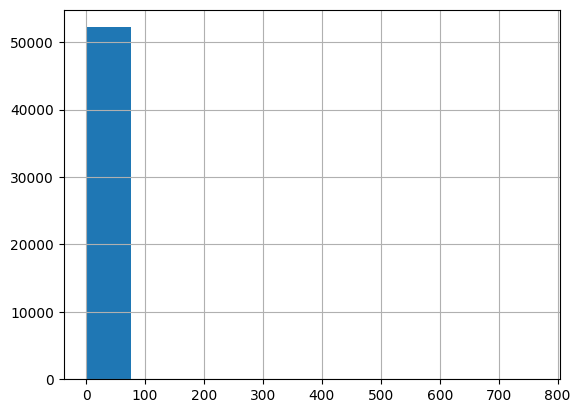

In [9]:
df_selected['secs_between_announcements'].hist()

<Axes: >

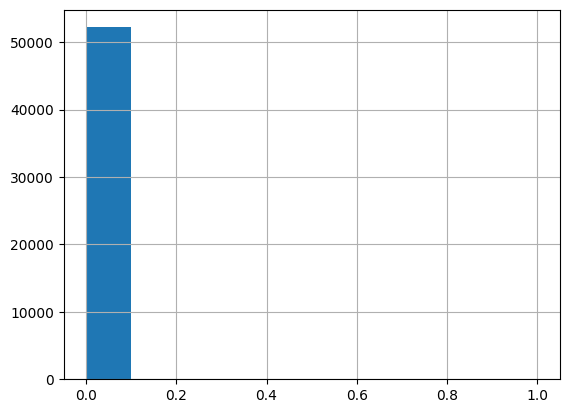

In [10]:
scaler_secs = MinMaxScaler(feature_range=(0, 1))
df_selected['secs_between_announcements'] = scaler_secs.fit_transform(
    df_selected[['secs_between_announcements']]
)

df_selected['secs_between_announcements'].hist()

In [11]:
display(df_selected)

,time,prefix,as_path_embedding,secs_between_announcements
0,1.270749e+09,208.98.231.0/24,"[-0.08015103, -0.056441247, -0.082175046, 0.03...",0.000000
1,1.270749e+09,217.169.80.0/20,"[-0.01731859, -0.03514917, -0.0110747125, -0.0...",0.001307
2,1.270749e+09,131.87.181.0/24,"[-0.051244948, -0.062330164, 0.0011569564, -0....",0.000000
3,1.270749e+09,131.87.181.0/24,"[-0.068379514, -0.062114824, 0.01263192, -0.05...",0.001307
4,1.270749e+09,199.60.22.0/24,"[-0.11192063, 0.027062032, -0.086402185, 0.015...",0.000000
...,...,...,...,...
52262,1.270750e+09,109.233.208.0/21,"[-0.028380737, -0.060629897, -0.07350309, -0.0...",0.001307
52263,1.270750e+09,109.233.208.0/21,"[0.019186145, -0.03814734, -0.0645254, -0.0039...",0.000000
52264,1.270750e+09,206.219.64.0/19,"[-0.050490614, 0.009129203, -0.047507904, 0.01...",0.000000
52265,1.270750e+09,206.219.64.0/19,"[-0.08803551, -0.051732346, -0.06333531, 0.066...",0.001307


## Creación del modelo Autoencoder

**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**
 
El objetivo es detectar comportamientos asociados a un secuestro de rutas BGP (BGP hijacking) utilizando datos sin etiquetas.
 
Por esta razón, se eligió un Autoencoder como modelo baseline, debido a que:
 
- Aprende sin etiquetas:
Captura la estructura del comportamiento normal de las rutas BGP sin requerir datos etiquetados.
 
- Detecta anomalías por reconstrucción:
Las muestras con alto error de reconstrucción se interpretan como posibles eventos anómalos o hijacks.
 
- Sirve como referencia inicial:
Proporciona una línea base de desempeño para comparar con modelos más avanzados que incorporen secuencias temporales (GRU, Transformer, etc.).
- Generaliza ante nuevos comportamientos:
Puede identificar desviaciones en las rutas incluso si no se observaron durante el entrenamiento.

### División del set de datos

- Entrenamiento: primeras 70 % de las filas → donde el modelo aprende la estructura y dinámica del evento.

- Validación: siguientes 15 % → para ajustar hiperparámetros (ej. tamaño del embedding latente, learning rate).

- Prueba: últimas 15 % → para evaluar el rendimiento en un tramo “futuro” no visto.

In [12]:
embeddings = np.stack(df_selected['as_path_embedding'].to_numpy())
scalars = df_selected[['secs_between_announcements']].to_numpy()

X = np.hstack([embeddings,scalars]).astype(np.float32)

In [13]:
N = len(X)
idx_train = int(N * 0.7)
idx_val = int(N * 0.85)

X_train = X[:idx_train]
X_val = X[idx_train:idx_val]
X_test = X[idx_val:]

y_train = X_train.copy()
y_val = X_val.copy()
y_test = X_test.copy()

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Creación de variables a tensores

In [15]:
X_train_tensor = torch.from_numpy(X_train)
X_val_tensor = torch.from_numpy(X_val)
X_test_tensor = torch.from_numpy(X_test)

y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)
y_test_tensor = torch.from_numpy(y_test)

Tensores a Datasets de PyTorch

In [16]:
ds_train = TensorDataset(X_train_tensor, y_train_tensor)
ds_val = TensorDataset(X_val_tensor, y_val_tensor)
ds_test = TensorDataset(X_test_tensor, y_test_tensor)

Datasets a DataLoader

- `shuffle=False` mantiene el orden temporal, lo que ayuda al análisis como serie de tiempo
- `pin_memory=True` acelera la transferencia CPU→GPU **si se usa CUDA**

In [17]:
batch_size = 2048

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=True)

In [18]:
print(f'Shapes -> \nTrain: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}')

Shapes -> 
Train: (36586, 385)
Val: (7840, 385)
Test: (7841, 385)


### Autoencoder simple con MLP

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim, latent_dim=64, p_drop=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(256, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(512, in_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z

In [20]:
in_dim = next(iter(train_loader))[0].shape[1]
print(f'Dimensiones de entrada: {in_dim}')

Dimensiones de entrada: 385


In [21]:
auto_encoder_mlp = AutoEncoder(in_dim=in_dim,
                               latent_dim=4,
                               p_drop=0.1).to(device)

criterion = nn.MSELoss(reduction='mean') # reconstrucción promedio por batch
optimizer = optim.Adam(auto_encoder_mlp.parameters(), lr=1e-3, weight_decay=1e-4)

#### Entrenamiento

In [23]:
def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion=nn.MSELoss(reduction='mean'),
    device=None,
    max_epochs=100,
    patience=10,
    min_delta=1e-6,
    target_val_loss=None,
    ckpt_dir="checkpoints",
    ckpt_name_best="best_model.pt",
    ckpt_name_last="last_model.pt",
    grad_clip_norm=1.0,
    use_amp=True,
    verbose=True,
):
    """
    Entrena 'model' con early stopping y guarda checkpoints.
    - Early stopping: se activa si 'val_loss' no mejora por 'patience' epochs.
    - target_val_loss: si se alcanza/descienta, se detiene de inmediato.
    - Guarda el mejor modelo y el último estado.
    """
    os.makedirs(ckpt_dir, exist_ok=True)
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    scaler = torch.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))

    best_state = None
    best_val = float('inf')
    wait = 0

    try:
        for epoch in range(1, max_epochs + 1):
            # --------------------
            #   ENTRENAMIENTO
            # --------------------
            model.train()
            train_loss_sum = 0.0
            n_train = 0

            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True).float()
                yb = yb.to(device, non_blocking=True).float()

                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast(device_type = device, enabled=(use_amp and torch.cuda.is_available())):
                    yhat, _ = model(xb)
                    loss = criterion(yhat, yb)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                if grad_clip_norm is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
                scaler.step(optimizer)
                scaler.update()

                train_loss_sum += loss.item() * xb.size(0)
                n_train += xb.size(0)

            train_loss = train_loss_sum / max(1, n_train)

            # --------------------
            #     VALIDACIÓN
            # --------------------
            model.eval()
            val_loss_sum = 0.0
            n_val = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device).float()
                    yb = yb.to(device).float()
                    yhat, _ = model(xb) if hasattr(model, 'encoder') else model(xb)
                    vloss = criterion(yhat, yb)
                    val_loss_sum += vloss.item() * xb.size(0)
                    n_val += xb.size(0)

            val_loss = val_loss_sum / max(1, n_val)

            if verbose:
                print(f"[{epoch:03d}] train_loss={train_loss:.6f}  val_loss={val_loss:.6f}")

            # --------------------
            #  CHECKPOINT + PARADA
            # --------------------
            improved = (best_val - val_loss) > min_delta
            if improved:
                best_val = val_loss
                wait = 0
                best_state = {
                    'epoch': epoch,
                    'model_state_dict': deepcopy(model.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                    'val_loss': best_val,
                }
                #torch.save(best_state, os.path.join(ckpt_dir, ckpt_name_best))
                torch.save(model, os.path.join(ckpt_dir, ckpt_name_best))
                if verbose:
                    print(f"✅ Mejoró val_loss. Guardado: {os.path.join(ckpt_dir, ckpt_name_best)}")
            else:
                wait += 1
                if verbose:
                    print(f"⚠️  Sin mejora ({wait}/{patience})")

            # Parada por objetivo absoluto
            if target_val_loss is not None and val_loss <= target_val_loss:
                if verbose:
                    print(f"🎯 target_val_loss alcanzado ({val_loss:.6f} ≤ {target_val_loss}). Deteniendo.")
                break

            # Early stopping por paciencia
            if wait >= patience:
                if verbose:
                    print(f"⏹️ Early stopping activado en epoch {epoch}. Mejor val_loss: {best_val:.6f}")
                break

        # Guardar último estado
        last_state = {
            'epoch': epoch,
            'model_state_dict': deepcopy(model.state_dict()),
            'optimizer_state_dict': deepcopy(optimizer.state_dict()),
            'val_loss': val_loss,
        }
        #torch.save(last_state, os.path.join(ckpt_dir, ckpt_name_last))
        torch.save(model, os.path.join(ckpt_dir, ckpt_name_last))
        if verbose:
            print(f"💾 Último estado guardado: {os.path.join(ckpt_dir, ckpt_name_last)}")

        # Restaurar mejor modelo
        if best_state is not None:
            model.load_state_dict(best_state['model_state_dict'])
            if verbose:
                print(f"✅ Modelo restaurado al mejor val_loss: {best_state['val_loss']:.6f} (epoch {best_state['epoch']})")

        return {
            'best_val_loss': best_val,
            'best_epoch': best_state['epoch'] if best_state else None,
            'last_val_loss': val_loss,
            'last_epoch': epoch,
            'best_ckpt_path': os.path.join(ckpt_dir, ckpt_name_best),
            'last_ckpt_path': os.path.join(ckpt_dir, ckpt_name_last),
        }

    except KeyboardInterrupt:
        # Interrupción manual segura
        interrupt_path = os.path.join(ckpt_dir, "interrupted_model.pt")
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'val_loss': val_loss,
        # }, interrupt_path)
        torch.save(model, interrupt_path)
        print(f"⏹️ Entrenamiento interrumpido. Modelo guardado en: {interrupt_path}")
        raise

In [24]:
history = train_with_early_stopping(
    model=auto_encoder_mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_epochs=50,
    patience=6,
    min_delta=1e-5,
    target_val_loss=1e-6,
    ckpt_dir=r"C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\checkpoints",
    verbose=True,
)

print(history)

[001] train_loss=0.001753  val_loss=0.001063
✅ Mejoró val_loss. Guardado: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\checkpoints\best_model.pt
[002] train_loss=0.001047  val_loss=0.001016
✅ Mejoró val_loss. Guardado: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\checkpoints\best_model.pt
[003] train_loss=0.000990  val_loss=0.001008
⚠️  Sin mejora (1/6)
[004] train_loss=0.000976  val_loss=0.001015
⚠️  Sin mejora (2/6)
[005] train_loss=0.000972  val_loss=0.001021
⚠️  Sin mejora (3/6)
[006] train_loss=0.000972  val_loss=0.001025
⚠️  Sin mejora (4/6)
[007] train_loss=0.000970  val_loss=0.001019
⚠️  Sin mejora (5/6)
[008] train_loss=0.000969  val_loss=0.001019
⚠️  Sin mejora (6/6)
⏹️ Early stopping activado en epoch 8. Mejor val_loss: 0.001016
💾 Último estado guardado: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\checkpoints\last_model.pt
✅ Modelo restaurado al mejor val_

#### Prueba del mejor modelo

In [25]:
best_mlp_model = torch.load(r"C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\checkpoints\best_model.pt", weights_only=False)
best_mlp_model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=385, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=385, bias=True)
  )
)

In [26]:
def evaluate_reconstruction(model, loader, device):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()

            y_hat, _ = model(xb)
            all_true.append(yb.cpu().numpy())
            all_pred.append(y_hat.cpu().numpy())

    y_true = np.concatenate(all_true, axis=0)
    y_pred = np.concatenate(all_pred, axis=0)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"MSE": mse, "MAE": mae, "R2":r2}

In [27]:
train_metrics = evaluate_reconstruction(best_mlp_model, train_loader, device)
val_metrics = evaluate_reconstruction(best_mlp_model, val_loader, device)
test_metrics = evaluate_reconstruction(best_mlp_model, test_loader, device)

print(f'Train: {train_metrics}')
print('*'*50)
print(f'Validation: {val_metrics}')
print('*'*50)
print(f'Test: {test_metrics}')
print('*'*50)

Train: {'MSE': 0.0009446560288779438, 'MAE': 0.024078888818621635, 'R2': -718159552.0}
**************************************************
Validation: {'MSE': 0.001015613554045558, 'MAE': 0.025029588490724564, 'R2': -775559936.0}
**************************************************
Test: {'MSE': 0.001032094587571919, 'MAE': 0.02530224248766899, 'R2': -1069440960.0}
**************************************************


**¿Cuál es la métrica adecuada para este problema de negocio?**

Dado que se emplea un modelo no supervisado, las métricas seleccionadas para evaluar su desempeño son el  `Mean Squared Error (MSE)` y el `Mean Absolute Error (MAE)`.
Ambas permiten cuantificar qué tan bien el modelo logra reconstruir los patrones aprendidos, en este caso, el comportamiento del tráfico durante un evento de secuestro de rutas.
Un menor valor en estas métricas indica una mejor capacidad del modelo para capturar y representar correctamente la estructura subyacente del fenómeno, lo cual resulta clave para identificar desviaciones y posibles anomalías.

**¿El modelo está sub/sobreajustando los datos de entrenamiento?**

Al analizar las métricas obtenidas en los conjuntos de `entrenamiento`, `validación` y `prueba`, se observa que las diferencias entre ellos son mínimas.
Esto indica que el modelo no presenta indicios de sobreajuste ni de subajuste, y que ha logrado generalizar adecuadamente el comportamiento aprendido a datos no vistos.

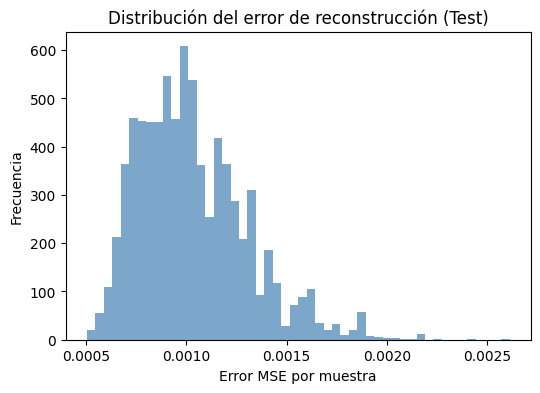

In [28]:
# Cálculo de error por muestra en test
def reconstruction_errors(model, loader):
    errs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            yhat, _ = model(xb)
            mse = ((yhat - yb) ** 2).mean(dim=1)
            errs.append(mse.cpu().numpy())
    return np.concatenate(errs)

test_err = reconstruction_errors(best_mlp_model, test_loader)

plt.figure(figsize=(6,4))
plt.hist(test_err, bins=50, color='steelblue', alpha=0.7)
plt.title("Distribución del error de reconstrucción (Test)")
plt.xlabel("Error MSE por muestra")
plt.ylabel("Frecuencia")
plt.show()

#### Gráfico del dataset completo

In [29]:
cols = [
    'time',
    'prefix',
    'as_path_embedding',
    'secs_between_announcements'
]

df_clean = (
    df[(df['type'] == 'A')]         # filtra solo anuncios
      [cols]                        # selecciona columnas
      .sort_values(by='time')       # ordena por tiempo
      .reset_index(drop=True)       # reinicia índice
      .fillna(0)
)

df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
time,280481.0,1.270750e+09,408.599795,1.270749e+09,1.270749e+09,1.270750e+09,1.270750e+09,1.270750e+09
secs_between_announcements,280481.0,7.856732e+00,44.615838,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.326000e+03


In [30]:
df_clean['secs_between_announcements'] = scaler_secs.transform(
    df_clean[['secs_between_announcements']]
)

display(df_clean.head(10))

,time,prefix,as_path_embedding,secs_between_announcements
0,1.270749e+09,119.235.30.0/24,"[-0.07192664, -0.053233534, -0.069591686, 0.02...",0.0
1,1.270749e+09,113.190.0.0/19,"[-0.07657978, -0.016463753, -0.15311258, 0.035...",0.0
2,1.270749e+09,119.235.16.0/24,"[-0.07192664, -0.053233534, -0.069591686, 0.02...",0.0
3,1.270749e+09,119.235.17.0/24,"[-0.07192664, -0.053233534, -0.069591686, 0.02...",0.0
4,1.270749e+09,113.162.160.0/19,"[-0.060665615, -0.062292065, -0.12526833, 0.00...",0.0
5,1.270749e+09,123.27.64.0/19,"[-0.06650915, -0.1240025, -0.0849231, -0.07972...",0.0
6,1.270749e+09,183.177.116.0/24,"[-0.0032957243, 0.03730718, -0.02650118, -0.02...",0.0
7,1.270749e+09,41.222.104.0/24,"[-0.018189741, -0.04644276, -0.13675475, 0.018...",0.0
8,1.270749e+09,204.124.160.0/22,"[-0.10416448, -0.09108144, -0.044444762, 0.000...",0.0
9,1.270749e+09,217.169.80.0/20,"[-0.052672926, -0.012109636, -0.091107816, -0....",0.0


In [31]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
time,280481.0,1.270750e+09,408.599795,1.270749e+09,1.270749e+09,1.270750e+09,1.270750e+09,1.270750e+09
secs_between_announcements,280481.0,1.027024e-02,0.058321,0.000000e+00,0.000000e+00,0.000000e+00,2.614379e-03,1.733333e+00


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_mlp_model.to(device)
best_mlp_model.eval()

all_embeddings = np.stack(df_clean['as_path_embedding'].to_numpy()).astype(np.float32)
all_scalers = df_clean[['secs_between_announcements']].to_numpy().astype(np.float32)

X_all = np.hstack([all_embeddings, all_scalers]).astype(np.float32)

times = pd.to_datetime(df_clean['time'], unit='s', utc=True).dt.strftime('%Y-%m-%d %H:%M:%S')

In [33]:
batch_size = 2048

ds_all = TensorDataset(torch.from_numpy(X_all), torch.from_numpy(X_all))
all_loader = DataLoader(ds_all, 
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=True)

In [34]:
err_all = reconstruction_errors(best_mlp_model, all_loader)

In [35]:
# threshold puede ser constante o tomar un percentil
threshold = np.percentile(err_all, 95)
flags = (err_all > threshold)

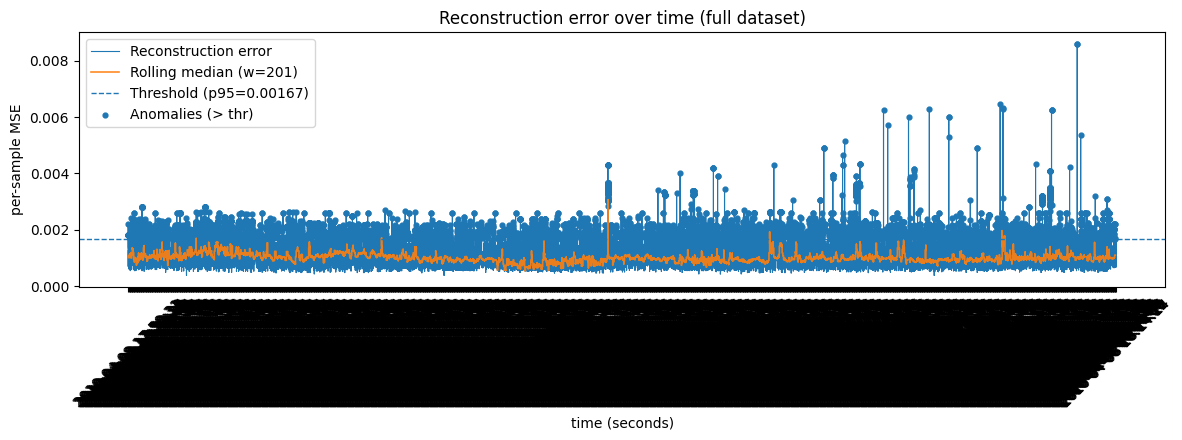

In [36]:
plt.figure(figsize=(12, 4.5))
plt.plot(times, err_all, linewidth=0.8, label='Reconstruction error')

# Suavizado opcional para lectura (mediana móvil)
try:
    smooth = pd.Series(err_all).rolling(201, center=True).median()
    plt.plot(times, smooth, linewidth=1.2, alpha=0.9, label='Rolling median (w=201)')
except Exception:
    pass

# Umbral (línea discontinua)
plt.axhline(threshold, linestyle='--', linewidth=1.0, label=f'Threshold (p95={threshold:.3g})')

# Puntos anómalos
anom_idx = np.where(flags)[0]
if anom_idx.size > 0:
    plt.scatter(times[anom_idx], err_all[anom_idx], s=12, marker='o', label='Anomalies (> thr)')

plt.title('Reconstruction error over time (full dataset)')
plt.xlabel('time (seconds)')
plt.ylabel('per-sample MSE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\reports\figures\reconstruction_error_all.png")
plt.show()

In [37]:
df_clean['time_str'] = pd.to_datetime(df_clean['time'], unit='s', utc=True)
df_clean['time_str'] = df_clean['time_str'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_plot = pd.DataFrame({
    'time': pd.to_datetime(df_clean['time_str'], utc=True),                   # en formato datetime UTC
    'reconstruction_error': err_all,               # errores calculados
})

df_plot.head()

,time,reconstruction_error
0,2010-04-08 17:50:31+00:00,0.001257
1,2010-04-08 17:50:31+00:00,0.001068
2,2010-04-08 17:50:31+00:00,0.001257
3,2010-04-08 17:50:31+00:00,0.001257
4,2010-04-08 17:50:31+00:00,0.000895


In [38]:
df_5min = df_plot.resample('10s', on='time').mean().reset_index()

# Verificar
print(df_5min.head())

                       time  reconstruction_error
0 2010-04-08 17:50:30+00:00              0.001112
1 2010-04-08 17:50:40+00:00              0.001012
2 2010-04-08 17:50:50+00:00              0.001154
3 2010-04-08 17:51:00+00:00              0.001099
4 2010-04-08 17:51:10+00:00              0.001114


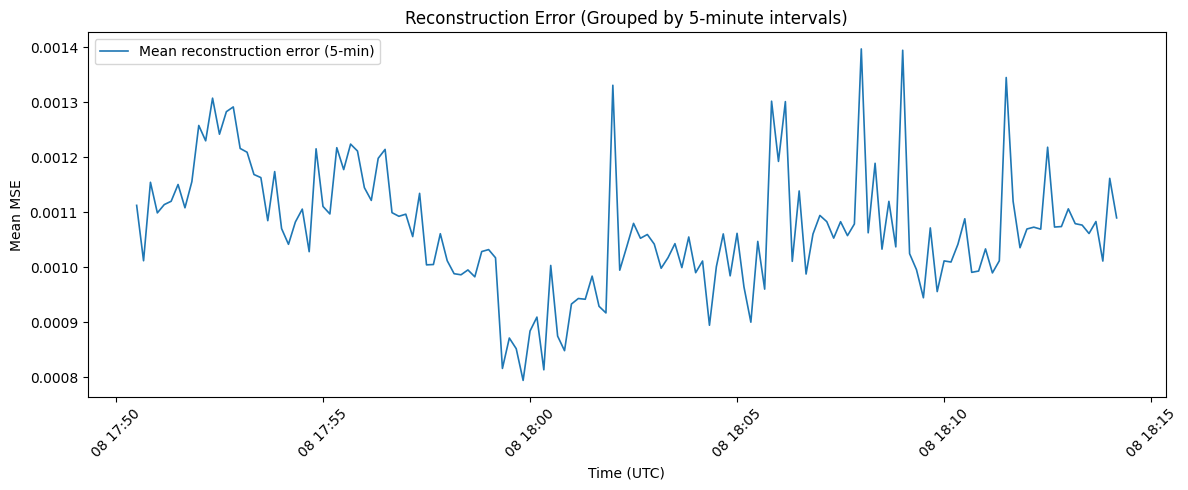

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(df_5min['time'], df_5min['reconstruction_error'],
         label='Mean reconstruction error (5-min)', linewidth=1.2)

plt.title('Reconstruction Error (Grouped by 5-minute intervals)')
plt.xlabel('Time (UTC)')
plt.ylabel('Mean MSE')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Agrupamiento de los errores

In [40]:
df_plot_k_means = pd.DataFrame({
    'time': pd.to_datetime(df_clean['time_str'], utc=True),
    'reconstruction_error': err_all
}).sort_values('time')

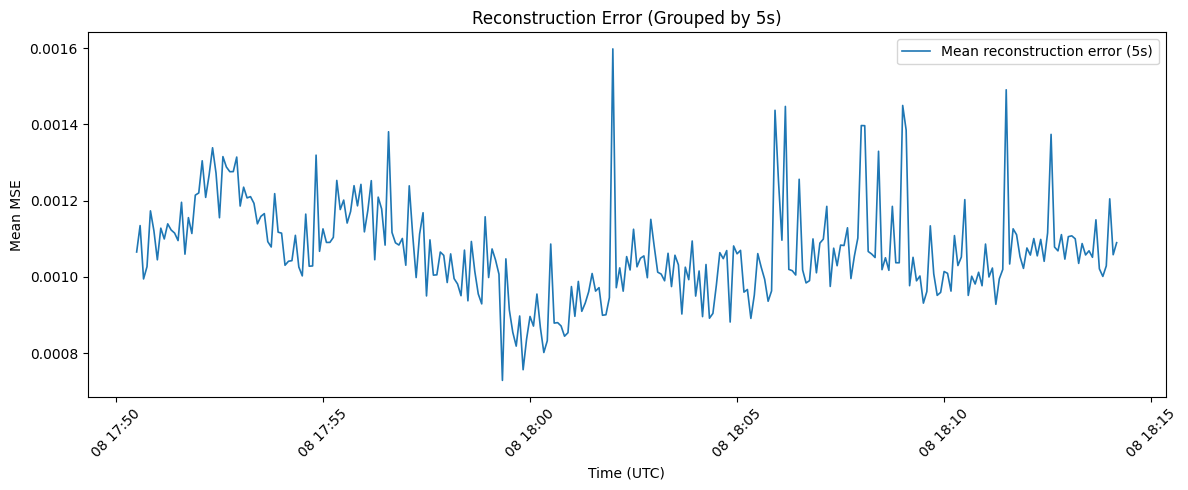

In [41]:
time_window = '5s'

df_plot = df_plot.sort_values('time')  # asegúrate de que esté ordenado
df_resampled = df_plot.resample(time_window, on='time').mean().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(df_resampled['time'], df_resampled['reconstruction_error'],
         linewidth=1.2, label=f'Mean reconstruction error ({time_window})')

plt.title(f'Reconstruction Error (Grouped by {time_window})')
plt.xlabel('Time (UTC)')
plt.ylabel('Mean MSE')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

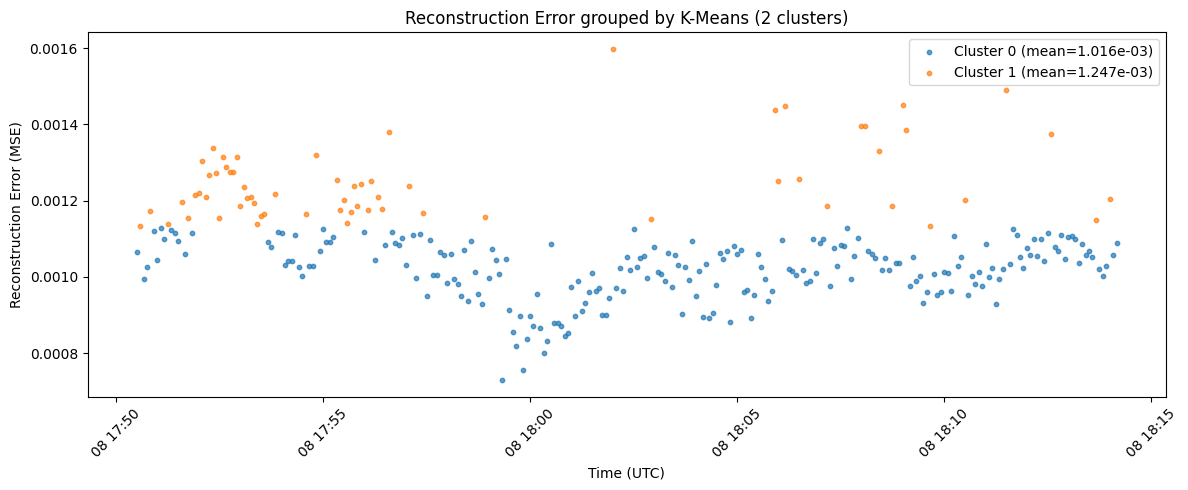

In [42]:
time_window = '5s'

df_plot_k_means = df_plot_k_means.sort_values('time')  # asegúrate de que esté ordenado
df_plot_k_means = df_plot_k_means.resample(time_window, on='time').mean().reset_index()

X = df_plot_k_means[['reconstruction_error']].to_numpy()

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_plot_k_means['cluster'] = kmeans.fit_predict(X)

# Determinar cuál grupo tiene mayor error promedio (probablemente anomalías)
cluster_means = df_plot_k_means.groupby('cluster')['reconstruction_error'].mean()
anom_cluster = cluster_means.idxmax()
df_plot_k_means['is_anomaly'] = (df_plot_k_means['cluster'] == anom_cluster).astype(int)

plt.figure(figsize=(12, 5))

# Dibujar cada grupo con color distinto
for cluster_id, cluster_data in df_plot_k_means.groupby('cluster'):
    plt.scatter(cluster_data['time'], cluster_data['reconstruction_error'],
                s=10, alpha=0.7,
                label=f'Cluster {cluster_id} (mean={cluster_data.reconstruction_error.mean():.3e})')

plt.title('Reconstruction Error grouped by K-Means (2 clusters)')
plt.xlabel('Time (UTC)')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

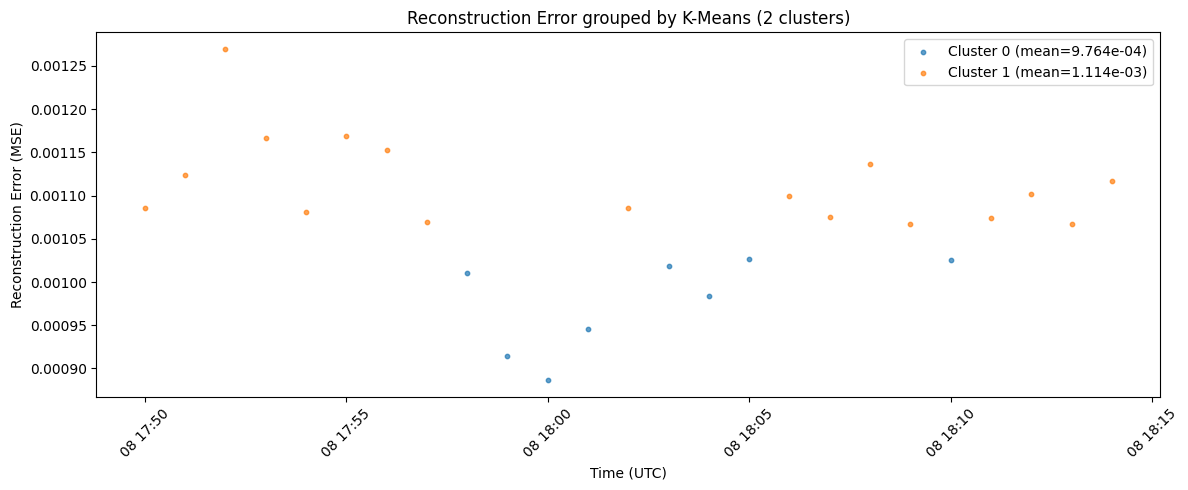

In [43]:
time_window = '1min'

df_plot_k_means_2 = df_plot_k_means.sort_values('time')  # asegúrate de que esté ordenado
df_plot_k_means_2 = df_plot_k_means.resample(time_window, on='time').mean().reset_index()

X_2 = df_plot_k_means_2[['reconstruction_error']].fillna(0).to_numpy()

kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df_plot_k_means_2['cluster'] = kmeans_2.fit_predict(X_2)

# Determinar cuál grupo tiene mayor error promedio (probablemente anomalías)
cluster_means_2 = df_plot_k_means_2.groupby('cluster')['reconstruction_error'].mean()
anom_cluster = cluster_means_2.idxmax()
df_plot_k_means_2['is_anomaly'] = (df_plot_k_means_2['cluster'] == anom_cluster).astype(int)

plt.figure(figsize=(12, 5))

# Dibujar cada grupo con color distinto
for cluster_id, cluster_data in df_plot_k_means_2.groupby('cluster'):
    plt.scatter(cluster_data['time'], cluster_data['reconstruction_error'],
                s=10, alpha=0.7,
                label=f'Cluster {cluster_id} (mean={cluster_data.reconstruction_error.mean():.3e})')

plt.title('Reconstruction Error grouped by K-Means (2 clusters)')
plt.xlabel('Time (UTC)')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusiones

El modelo desarrollado demuestra un comportamiento estable y generalizable, manteniendo valores consistentes de error entre los conjuntos de `entrenamiento`, `validación` y `prueba`. Para su evaluación se utilizaron las métricas `MSE` y `MAE`, siendo las más adecuadas para medir la capacidad del modelo para **reconstruir** los patrones característicos del tráfico durante los eventos de **secuestro de rutas BGP**, sin contar con etiquetas en los datos.

Estos resultados denotan que el modelo ha aprendido de manera efectiva la estructura de los datos, constituyendo una base sólida para futuros desarrollos.

Como modelos alternativos, se propone explorar modelos que incorporen la dimensión temporal, como lo son autoencoders secuenciales basados en `GRU` o `LSTM`, esto con el fin de capturar dependencias dinámicas en el tiempo, mejorar el rendimiento, y permitir una comparación directa con el modelo base.